# Fit

### Imports

In [20]:
import emcee, corner
import numpy as np
import matplotlib.pyplot as plt
from model import read_data, doppler_shift, filter_by_theta, get_spectra, bins_to_x

% matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=30)

### Constants

In [ ]:
VROT_MIN = 0.0
VROT_MAX = 600.0
THETA_MIN = 0.0
THETA_MAX = np.pi/2.0
NUM_THETAS = 9
THETAS_RANGE = np.arccos(np.linspace(1, 0, NUM_THETAS))
N_STEPS = 500

### Functions

In [1]:
def get_theta_range(theta):
    '''Returns the range of theta in a cosine linear space.'''
    min_theta = THETAS_RANGE[0]
    max_theta = THETAS_RANGE[1]
    for i in range(NUM_THETAS-1):
        min_theta = THETAS_RANGE[i]
        max_theta = THETAS_RANGE[i+1]
        if (theta >= min_theta and theta <= max_theta):
            break
    return min_theta, max_theta

def model(data_doppler, vrot, theta):
    '''Model.'''
    doppler = doppler_shift(data_doppler, vrot=vrot)
    min_theta, max_theta = get_theta_range(theta)
    doppler_theta = filter_by_theta(doppler, min_theta=min_theta,
                                    max_theta=max_theta)
    b_m, n_m = get_spectra(doppler_theta)
    return b_m, n_m

def get_difference(b_m, n_m, x_d, y_d):
    '''Use the data resolution to subtract model and data.'''
    # kulas is wider than model
    diff = []
    ind = 0
    for i in range(len(x_d)):
        x = x_d[i]
        if (x<np.amin(b_m) or x>np.amax(b_m)):
            diff.append( y_d[i] )
        else:
            is_x_at_ind = (x>=b_m[ind] and x<=b_m[ind+1])
            while (not is_x_at_ind):
                ind += 1
                is_x_at_ind = (x>=b_m[ind] and x<=b_m[ind+1])
            diff.append( y_d[i] - n_m[ind] )
    diff = np.array(diff)
    return diff

def ln_prior(param):
    '''Log of prior.'''
    vrot, theta = param
    if ((VROT_MIN <= vrot <= VROT_MAX) and (THETA_MIN <= theta <= THETA_MAX)):
        return 0.0
    return -np.inf

def ln_likelihood(param, x_d, y_d, data_doppler):
    '''Log of likelihood function.'''
    vrot, theta = param
    b_m, n_m = model(data_doppler, vrot, theta)
    diff = get_difference(b_m, n_m, x_d, y_d)
    chi_squared = np.sum(diff**2)
    return -0.5*chi_squared

def ln_probability(param, x_d, y_d, data_doppler):
    '''Log of probability function.'''
    lp = ln_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(param, x_d, y_d, data_doppler)

def emcee_kulas(x_d, y_d, data_doppler):
    '''Emcee implementation.'''
    # First guess
    vrot = VROT_MAX/2.0
    theta = THETA_MAX
    first_guess = [vrot, theta]

    # Running emcee
    ndim = 2
    nwalkers = 8
    nsteps = N_STEPS

    pos = [first_guess+ 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_probability,
                                    args=(x_d, y_d, data_doppler), threads=8)

    sampler.run_mcmc(pos, nsteps, rstate0=np.random.get_state())

    # Saving results
    samples_fc = sampler.flatchain
    #logprob_fc = sampler.flatlnprobability
    #np.savetxt('sampler_flatchain.dat', samples_fc, delimiter=',')

    # Should be between approximately 0.25 and 0.5 if everything went as planned
    maf_msg = "Mean acceptance fraction: {0:.3f} (0.25 < m.a.f. <0.5 approx)"
    print(maf_msg.format(np.mean(sampler.acceptance_fraction)))

    # Discard the initial 50 steps
    samples = samples_fc[50:]
    #logprob = logprob_fc[50:]

    # Unpack the walk for each parameter
    vrot_walk, theta_walk = np.transpose(samples)

    # Extract the percentiles for each parameter
    vrot_mcmc = np.percentile(vrot_walk, [16, 50, 84])
    theta_mcmc = np.percentile(theta_walk, [16, 50, 84])

    # Takes the best parameters as the 50 percentile
    vrot_best = vrot_mcmc[1]
    theta_best = theta_mcmc[1]

    # Prints them
    #print('Parameter = [16 50 84]')
    #print('vrot = ', vrot_mcmc)
    #print('theta = ', theta_mcmc)

    fig = corner.corner(samples, labels=[r"$v_{rot}$", r"$\theta$"],
                        quantiles=[0.16, 0.5, 0.84])
    return vrot_best, theta_best, fig

def plot_spectra(x_m, y_m, x_d, y_d, alpha=1.0, lw=2, fn="fit_emcee.png"):
    '''To plot results.'''

    y_fw = [] # to plot y_m as it was used to get the difference
    ind = 0
    for i in range(len(x_d)):
        x = x_d[i]
        if (x<np.amin(x_m) or x>np.amax(x_m)):
            y_fw.append( 0.0 )
        else:
            is_x_at_ind = (x>=x_m[ind] and x<=x_m[ind+1])
            while (not is_x_at_ind):
                ind += 1
                is_x_at_ind = (x>=x_m[ind] and x<=x_m[ind+1])
            y_fw.append( y_m[ind] )
    y_fw = np.array(y_fw)

    b = len(x_m)
    plt.figure()
    #plt.hist(x_m, weights=y_m, histtype='step', fill=False, normed=True,
    #         color='black', linewidth=lw, bins=b, alpha=alpha, label='Emcee')
    plt.hist(x_d, weights=y_fw, histtype='step', fill=False, normed=True,
             color='black', linewidth=lw, bins=b, alpha=alpha, label='Emcee')
    plt.hist(x_d, weights=y_d, histtype='step', fill=False, normed=True,
             color='black', linewidth=1, bins=b, linestyle='--', label='Kulas')
    plt.legend()
    plt.savefig(fn)

def preprocess_data(data):
    '''To preprocess Kulas.'''
    x_d, y_d = data[:,0], data[:,1]
    x_d = x_d/(1+2.5954)
    x_p, y_p = [], []
    dx = 20
    x = -500
    end = 500
    while (x <= end):
        if (x < np.amin(x_d) or x > np.amax(x_d)):
            y_p.append(0.0)
        else:
            y = np.interp(x, x_d, y_d)
            y_p.append(y)
        x_p.append(x)
        x += dx
    x_p = np.array(x_p)
    y_p = np.array(y_p)

    area = np.trapz(y_p, x_p)
    y_p = (y_p/area)

    return x_p, y_p

### Data

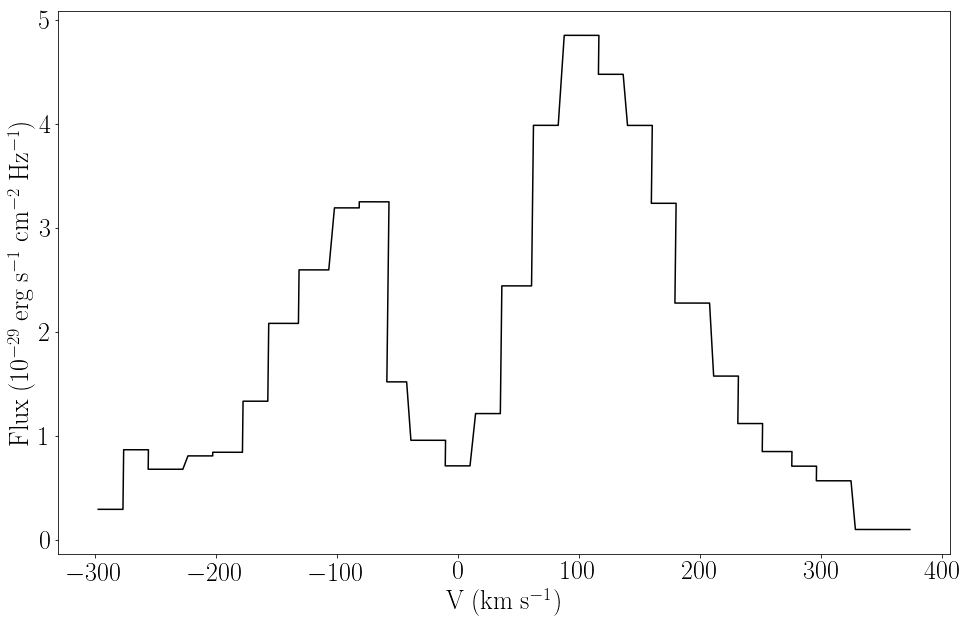

In [18]:
# Kulas data
data = np.loadtxt('./discussion/fit_kulas.csv', delimiter=',')
x_d, y_d = preprocess_data(kulas)

# Input
vrot0 = 0
vout = 5

### Emcee

In [ ]:
# logtau = 6
logtau_6 = 6
data_6 = read_data(vrot0, vout, logtau_6)
vrot_6, theta_6, fig_6 = emcee_kulas(x_d, y_d, data_6)
b_6, y_6 = model(data_6, vrot_6, theta_6)
np.savetxt("./discussion/fit_results_6.txt", [vrot_6, theta_6])
x_6 = bins_to_x(b_6)
plot_spectra(x_6, y_6, x_d, y_d, fn="fit_emcee_6.png")
fig_6.savefig("./discussion/fit_triangle_6.png", dpi=200)

In [ ]:
# logtau = 7
logtau_7 = 7
data_7 = read_data(vrot0, vout, logtau_7)
vrot_7, theta_7, fig_7 = emcee_kulas(x_d, y_d, data_7)
b_7, y_7 = model(data_7, vrot_7, theta_7)
np.savetxt("./discussion/fit_results_7.txt", [vrot_7, theta_7])
x_7 = bins_to_x(b_7)
plot_spectra(x_7, y_7, x_d, y_d, fn="fit_emcee_7.png")
fig_7.savefig("./discussion/fit_triangle_7.png", dpi=200)

In [ ]:
# my plots
vrot = 270
theta = 0.1
bins, y_m = model(data_6, vrot, theta)
x_m = bins_to_x(bins)
plot_spectra(x_m, y_m, x_d, y_d, fn="fit_mines/mine_6_"+str(vrot)+"_"+str(theta)+".png")